In [1]:
import os

os.chdir('app/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor

In [3]:
path_to_data = 'data'

In [16]:
df_train = pd.read_parquet(path_to_data + '/train_dataset_hackaton2023_train.gzip')
df_test = pd.read_parquet(path_to_data + '/hackaton2023_test.gzip')

df_test['date_diff_post'] = 0
df_test['buy_post'] = 0

In [17]:
mapping = pd.read_csv('mapping_2.csv')
df_train['dish_category'] = df_train['dish_name'].map(mapping.set_index('dish_name')['dish_category'])

In [19]:
# ohe = OneHotEncoder()
# dish_category_ohe = ohe.fit_transform(df_train[['dish_category']])
# dish_category_ohe = pd.DataFrame(dish_category_ohe.A, columns=ohe.get_feature_names_out())

# df_train_ohe = pd.concat([df_train, dish_category_ohe], axis=1)

In [20]:
data_check_agg = df_train.groupby(['customer_id', 'startdatetime']).agg({
        'revenue': 'sum', 
        'revenue': 'count', 
        'buy_post': 'first',
        'date_diff_post': 'first',
        'dish_category': lambda x: list(x)
}).reset_index()

In [22]:
corpus = ['|'.join(check) for check in list(data_check_agg['dish_category'])]

In [23]:
tfidf = TfidfVectorizer(tokenizer= lambda x: x.split('|'))
res = tfidf.fit_transform(corpus)

/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
tfidf_features = pd.DataFrame(res.A, columns=tfidf.get_feature_names_out())

In [25]:
data_check_agg_tf_idf = pd.concat([data_check_agg, tfidf_features], axis=1)# 

In [26]:
data_check_agg_tf_idf

,customer_id,startdatetime,revenue,buy_post,date_diff_post,dish_category,бургер,десерт,дополнительно,закуски,напитки,прочее,ролл,соус
0,29891,2022-12-05 12:03:58,4,1,9.0,"[Закуски, Бургер, Соус, Напитки]",0.431347,0.000000,0.0,0.437767,0.463336,0.0,0.000000,0.63845
1,29891,2022-12-05 14:28:35,1,1,9.0,[Напитки],0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.00000
2,29891,2022-12-15 00:37:19,2,1,9.0,"[Бургер, Ролл]",0.402310,0.000000,0.0,0.000000,0.000000,0.0,0.915503,0.00000
3,29891,2022-12-20 09:20:38,1,1,9.0,[Бургер],1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000
4,29891,2022-12-21 09:46:23,1,1,9.0,[Бургер],1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880581,46654016,2023-08-01 14:04:28,1,1,15.0,[Напитки],0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.00000
2880582,46654016,2023-08-01 18:15:31,2,1,15.0,"[Бургер, Напитки]",0.681389,0.000000,0.0,0.000000,0.731921,0.0,0.000000,0.00000
2880583,46661804,2023-08-01 17:50:26,3,0,NaN,"[Бургер, Закуски, Напитки]",0.560436,0.000000,0.0,0.568778,0.601999,0.0,0.000000,0.00000
2880584,46661804,2023-08-01 18:01:40,6,0,NaN,"[Закуски, Бургер, Десерт, Закуски, Напитки, За...",0.261285,0.469153,0.0,0.795522,0.280662,0.0,0.000000,0.00000


In [27]:
data_check_agg_tf_idf['delta'] = data_check_agg_tf_idf.groupby('customer_id')['startdatetime'].diff() 

data_check_agg_tf_idf['delta_hours'] = (data_check_agg_tf_idf['delta'].dt.total_seconds() // (60*60)).fillna(0)
data_check_agg_tf_idf['delta_days'] = (data_check_agg_tf_idf['delta'].dt.total_seconds() // (24*60*60)).fillna(0)

In [28]:
data_cust_agg = data_check_agg_tf_idf.groupby('customer_id').agg({
    'revenue': ['mean', 'median', 'std', 'max', 'min', 'count'],
    'delta_hours': ['mean', 'median', 'std', 'max'], 
    'delta_days': ['mean', 'median', 'std', 'max'], 
    'startdatetime': ['min', 'max'],
    'buy_post': 'first',
    'date_diff_post': 'first',
} | {
    col: ['mean', 'median', 'std', 'max', 'min'] for col in tfidf_features.columns
}).reset_index()

In [29]:
data_cust_agg.columns = [f'{header}_{stat}' for header, stat in data_cust_agg.columns]

In [30]:
data_cust_agg['recency'] = (data_cust_agg['startdatetime_max'] - data_cust_agg['startdatetime_min']).dt.days
data_cust_agg['T'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_min']).dt.days
data_cust_agg['days_from_last_purchase'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_max']).dt.days
data_cust_agg['lambda'] = data_cust_agg['revenue_count'] / (data_cust_agg['recency'] + 1)

In [31]:
data_train, data_valid = train_test_split(data_cust_agg, test_size=.2, random_state=42)

In [32]:
X_train = data_train.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_', 'startdatetime_max', 'startdatetime_min'], axis=1)
y_train_class = data_train['buy_post_first']
y_train_reg = data_train['date_diff_post_first']

X_valid = data_valid.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_', 'startdatetime_max', 'startdatetime_min'], axis=1)
y_valid_class = data_valid['buy_post_first']
y_valid_reg = data_valid['date_diff_post_first']

# X_test = data_test.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)

In [34]:
model = LGBMClassifier(n_estimators=100, verbose=-1)#, class_weight={0: .8, 1: .2})
# model = LogisticRegression()

model.fit(X_train, y_train_class)

LGBMClassifier(verbose=-1)

In [35]:
print(f'Train ROC-AUC: {roc_auc_score(y_train_class, model.predict_proba(X_train)[:, 1])}')
print(f'Valid ROC-AUC: {roc_auc_score(y_valid_class, model.predict_proba(X_valid)[:, 1])}')

Train ROC-AUC: 0.7581584588057416
Valid ROC-AUC: 0.7470393319975079


In [36]:
print(f'Train ROC-AUC: {f1_score(y_train_class, model.predict(X_train))}')
print(f'Valid ROC-AUC: {f1_score(y_valid_class, model.predict(X_valid))}')

Train ROC-AUC: 0.8430261742560058
Valid ROC-AUC: 0.8425436688008952


<Axes: >

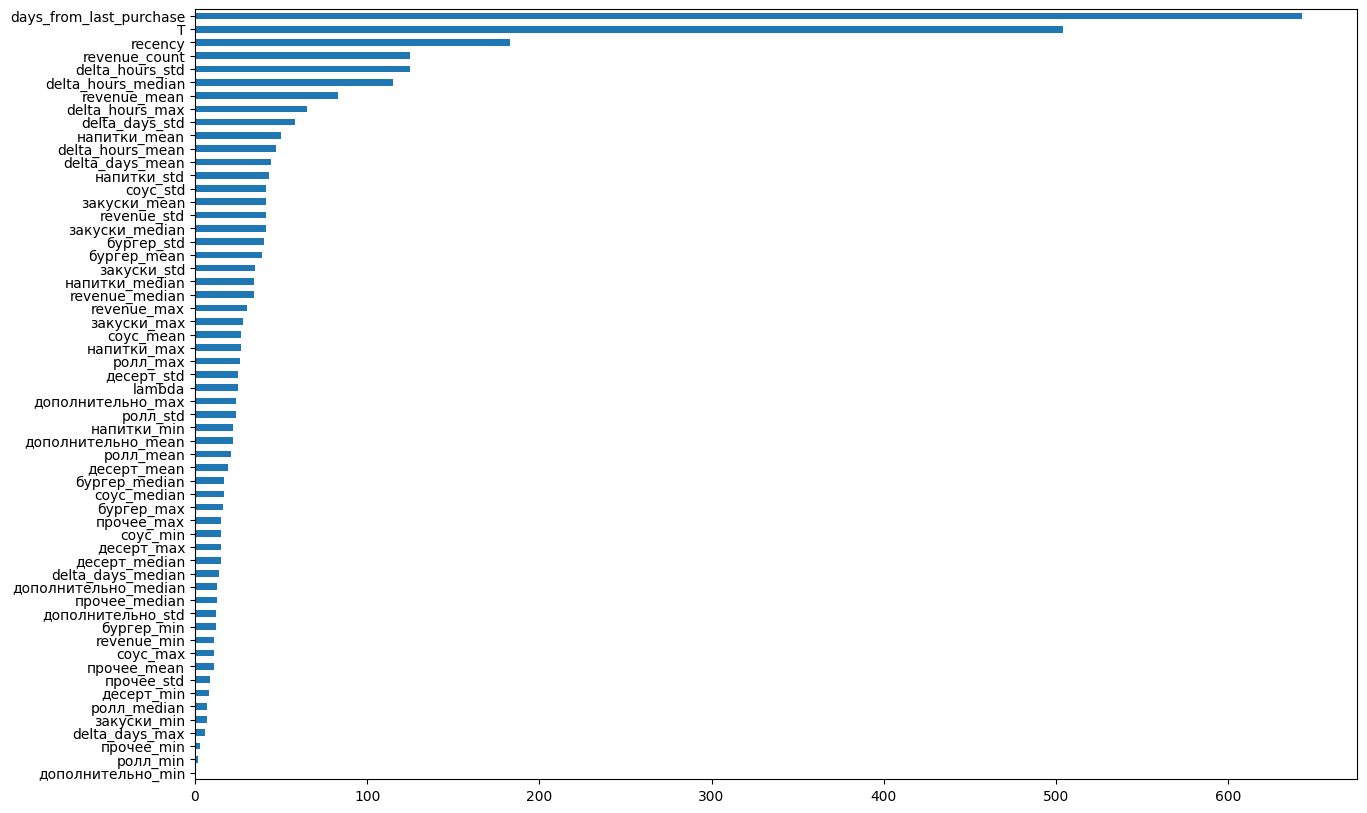

In [42]:
plt.figure(figsize=(15, 10))

pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')

In [127]:
def preprocess(df):
    # df = df.drop_duplicates()

    data_check_agg = df.groupby(['customer_id', 'startdatetime']).agg({
        'revenue': 'sum', 
        'buy_post': 'first',
        'date_diff_post': 'first'
    }).reset_index()

    data_check_agg['delta'] = data_check_agg.groupby('customer_id')['startdatetime'].diff() 

    data_check_agg['delta_hours'] = (data_check_agg['delta'].dt.total_seconds() // (60*60)).fillna(0)
    data_check_agg['delta_days'] = (data_check_agg['delta'].dt.total_seconds() // (24*60*60)).fillna(0)

    data_check_agg = data_check_agg.drop('delta', axis=1)

    data_cust_agg = data_check_agg.groupby('customer_id').agg({
        'revenue': ['mean', 'median', 'std', 'max', 'min', 'count'],
        'delta_hours': ['mean', 'median', 'std', 'max', 'min',], 
        'delta_days': ['mean', 'median', 'std', 'max', 'min',], 
        'startdatetime': ['min', 'max'],
        'buy_post': 'first',
        'date_diff_post': 'first',
    }).reset_index()

    data_cust_agg.columns = [f'{header}_{stat}' for header, stat in data_cust_agg.columns]

    data_cust_agg['recency'] = (data_cust_agg['startdatetime_max'] - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['T'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['days_from_last_purchase'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_max']).dt.days
    data_cust_agg['lambda'] = data_cust_agg['revenue_count'] / (data_cust_agg['recency'] + 1)
    data_cust_agg = data_cust_agg.drop(['startdatetime_min', 'startdatetime_max'], axis=1)
    
    return data_cust_agg

In [128]:
data_train = preprocess(df_train)

In [131]:
data_train.head()

,customer_id_,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,delta_hours_mean,delta_hours_median,delta_hours_std,...,delta_days_median,delta_days_std,delta_days_max,delta_days_min,buy_post_first,date_diff_post_first,recency,T,days_from_last_purchase,lambda
0,29891,203.494000,199.960,123.170275,439.98,1.00,25,55.240000,24.0,72.502460,...,1.0,2.998889,11.0,0.0,1,9.0,57,239,181,0.431034
1,30477,227.024000,229.990,124.933425,499.95,44.99,25,49.400000,23.0,60.578462,...,0.0,2.518597,9.0,0.0,1,10.0,51,301,249,0.480769
2,31426,391.399583,344.985,334.849322,1079.97,1.00,24,49.708333,34.5,46.635944,...,1.0,1.809796,6.0,0.0,1,4.0,50,81,31,0.470588
3,44491,128.725000,59.980,144.471912,344.97,49.97,4,166.750000,11.5,318.351352,...,0.0,13.000000,26.0,0.0,1,42.0,27,52,24,0.142857
4,44939,554.943333,554.940,49.985000,604.93,504.96,3,123.333333,172.0,107.598017,...,7.0,4.358899,8.0,0.0,1,9.0,15,234,219,0.187500


In [132]:
data_test = preprocess(df_test)

In [133]:
data_test.head()

,customer_id_,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,delta_hours_mean,delta_hours_median,delta_hours_std,...,delta_days_median,delta_days_std,delta_days_max,delta_days_min,buy_post_first,date_diff_post_first,recency,T,days_from_last_purchase,lambda
0,52341,563.942500,549.95,65.700330,655.93,499.94,4,192.000000,168.0,178.529176,...,6.5,7.500000,18.0,0.0,0,0,32,178,146,0.121212
1,69175,430.306667,399.98,62.142941,554.96,374.98,9,92.777778,24.0,131.890843,...,1.0,5.456902,13.0,0.0,0,0,34,40,5,0.257143
2,73427,254.240323,169.98,218.360745,869.95,1.00,31,45.096774,45.0,43.356164,...,1.0,1.786448,8.0,0.0,0,0,58,212,153,0.525424
3,134577,372.970000,290.98,310.195853,799.93,109.99,4,35.000000,0.0,70.000000,...,0.0,2.500000,5.0,0.0,0,0,5,316,310,0.666667
4,156357,558.963333,644.96,245.551523,749.95,281.98,3,344.000000,138.0,481.285778,...,5.0,20.074860,37.0,0.0,0,0,43,227,184,0.068182


In [103]:
# data_train, data_valid = train_test_split(data_cust_agg, test_size=.2, random_state=42)

In [135]:
X_train = data_train.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)
y_train_class = data_train['buy_post_first']
y_train_reg = data_train['date_diff_post_first']

# X_valid = data_valid.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_', 'startdatetime_min', 'startdatetime_max'], axis=1)
# y_valid_class = data_valid['buy_post_first']
# y_valid_reg = data_valid['date_diff_post_first']

X_test = data_test.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)

In [164]:
y_train_class.mean()

0.71819

In [136]:
model = LGBMClassifier(verbose=-1)
# model = LogisticRegression()

res = cross_val_score(model, X_train, y_train_class, scoring='roc_auc')
print(f'ROC-AUC: {res.mean():.3f} ± {res.std():.3f}')

ROC-AUC: 0.749 ± 0.001


In [137]:
res = cross_val_score(model, X_train, y_train_class, scoring='f1')
print(f'f1-score: {res.mean():.3f} ± {res.std():.3f}')

f1-score: 0.841 ± 0.001


In [138]:
model = LGBMRegressor(verbose=-1)
# model = LinearRegression()

res = cross_val_score(model, X_train, y_train_reg.fillna(0), scoring='neg_root_mean_squared_error')
print(f'RMSE: {-res.mean():.3f} ± {res.std():.3f}')

RMSE: 16.686 ± 0.207


In [141]:
model_class = LGBMClassifier(verbose=-1)
model_class.fit(X_train, y_train_class)

LGBMClassifier(verbose=-1)

In [144]:
model_reg = LGBMRegressor(verbose=-1)
model_reg.fit(X_train, y_train_reg.fillna(0))

LGBMRegressor(verbose=-1)

In [167]:
pred_class = model_class.predict_proba(X_test)[:, 1]
pred_reg = model_reg.predict(X_test)

In [171]:
b = []

for t in np.linspace(0, 1, 100):
    b.append((pred_class >= t).mean())

In [177]:
#.mean()

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

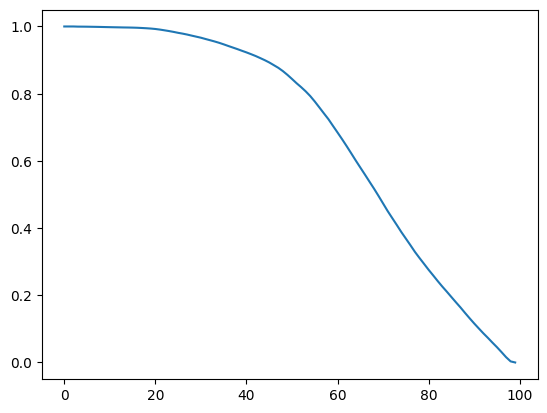

In [173]:
plt.plot(b)

In [178]:
sub = pd.DataFrame()

sub['customer_id'] = data_test['customer_id_']
sub['date_diff_post'] = pred_reg
sub['buy_post'] = np.int32(pred_class >= 0.85)

In [180]:
sub.to_csv('dump_correction.csv', sep=';', index=False)

In [182]:
sub.mean()

customer_id       2.074861e+07
date_diff_post    1.756574e+01
buy_post          2.083341e-01
dtype: float64

In [157]:
submission = pd.read_csv('submission.csv', sep=';')
submission

,customer_id,date_diff_post,buy_post
0,13220760,0,0
1,30315975,0,0
2,21679985,0,0
3,29754274,0,0
4,7797823,0,0
...,...,...,...
112329,14023374,0,0
112330,34923292,0,0
112331,32761835,0,0
112332,38322785,0,0


In [161]:
submission

,customer_id,date_diff_post,buy_post
0,13220760,0,0
1,30315975,0,0
2,21679985,0,0
3,29754274,0,0
4,7797823,0,0
...,...,...,...
112329,14023374,0,0
112330,34923292,0,0
112331,32761835,0,0
112332,38322785,0,0


In [162]:
submission[['customer_id']].merge(sub).to_csv('second_sub.csv', sep=';', index=False)
# sub.to_csv('first_sub.csv', sep=';', index=False)